<a href="https://colab.research.google.com/github/tg-bomze/BabyGAN/blob/master/BabyGAN_(ENG).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#![](https://raw.githubusercontent.com/tg-bomze/BabyGAN/master/media/logo.png)

<b><font color="black" size="+2">Based on:</font></b>

**GitHub repository: [BabyGAN](https://github.com/tg-bomze/BabyGAN)**

*Creator: [Denis Malimonov](https://github.com/tg-bomze)*

---
<b><font color="black" size="+1">Used:</font></b>

Neural Network: **[StyleGAN](https://github.com/NVlabs/stylegan)** (*Creators: [Tero Karras](https://research.nvidia.com/person/tero-karras), [Samuli Laine](https://research.nvidia.com/person/samuli-laine), [Timo Aila](https://research.nvidia.com/person/timo-aila)*)

Encoder: **[stylegan-encoder](https://github.com/pbaylies/stylegan-encoder)** *(Creators: [Peter Baylies](https://github.com/pbaylies), [Dmitry Nikitko](https://github.com/Puzer))*

---


```
To get started, click on the button (where the red arrow indicates). After clicking, wait until the execution is complete.
```


In [ ]:
# !pip install 'h5py<3.0.0'

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
import os
import cv2
import math
import pickle
import imageio
import PIL.Image
import numpy as np
from PIL import Image
import tensorflow as tf
from random import randrange
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [4]:
def get_watermarked(pil_image: Image) -> Image:
  try:
    image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
    (h, w) = image.shape[:2]
    image = np.dstack([image, np.ones((h, w), dtype="uint8") * 255])
    pct = 0.08
    full_watermark = cv2.imread('./media/logo.png', cv2.IMREAD_UNCHANGED)
    (fwH, fwW) = full_watermark.shape[:2]
    wH = int(pct * h*2)
    wW = int((wH * fwW) / fwH*0.1)
    watermark = cv2.resize(full_watermark, (wH, wW), interpolation=cv2.INTER_AREA)
    overlay = np.zeros((h, w, 4), dtype="uint8")
    (wH, wW) = watermark.shape[:2]
    overlay[h - wH - 10 : h - 10, 10 : 10 + wW] = watermark
    output = image.copy()
    cv2.addWeighted(overlay, 0.5, output, 1.0, 0, output)
    rgb_image = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    return Image.fromarray(rgb_image)
  except: return pil_image

In [5]:
def generate_final_images(latent_vector, direction, coeffs, i):
    new_latent_vector = latent_vector.copy()
    new_latent_vector[:8] = (latent_vector + coeffs * direction)[:8]
    new_latent_vector = new_latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(new_latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    if size[0] >= 512: img = get_watermarked(img)
    img_path = "./for_animation/" + str(i) + ".png"
    img.thumbnail(animation_size, PIL.Image.ANTIALIAS)
    img.save(img_path)
    face_img.append(imageio.imread(img_path))
    clear_output()
    return img

In [6]:
def generate_final_image(latent_vector, direction, coeffs):
    new_latent_vector = latent_vector.copy()
    new_latent_vector[:8] = (latent_vector + coeffs * direction)[:8]
    new_latent_vector = new_latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(new_latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    if size[0] >= 512: img = get_watermarked(img)
    img.thumbnail(size, PIL.Image.ANTIALIAS)
    img.save("face.png")
    # if download_image == True: files.download("face.png")
    return img

In [7]:
def plot_three_images(imgB, fs=10):
  f, axarr = plt.subplots(1, 3, figsize=(fs,fs))
  axarr[0].imshow(Image.open('./aligned_images/father_01.png'))
  axarr[0].title.set_text("Father's photo")
  axarr[1].imshow(imgB)
  axarr[1].title.set_text("Child's photo")
  axarr[2].imshow(Image.open('./aligned_images/mother_01.png'))
  axarr[2].title.set_text("Mother's photo")
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

In [8]:
directories = ["aligned_images", "data", "father_image", "mother_image"]
for directory in directories:
    if not os.path.exists(f'./{directory}'):
        os.mkdir(directory)

In [9]:
import config
import dnnlib
import dnnlib.tflib as tflib
from encoder.generator_model import Generator

In [10]:
age_direction = np.load('./ffhq_dataset/latent_directions/age.npy')
horizontal_direction = np.load('./ffhq_dataset/latent_directions/angle_horizontal.npy')
vertical_direction = np.load('./ffhq_dataset/latent_directions/angle_vertical.npy')
eyes_open_direction = np.load('./ffhq_dataset/latent_directions/eyes_open.npy')
gender_direction = np.load('./ffhq_dataset/latent_directions/gender.npy')
smile_direction = np.load('./ffhq_dataset/latent_directions/smile.npy')

In [10]:
!python align_images.py ./father_image ./aligned_images

Aligning father_1.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result ./aligned_images\father_1_01.png


2022-12-10 15:24:33.578393: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll
Using TensorFlow backend.


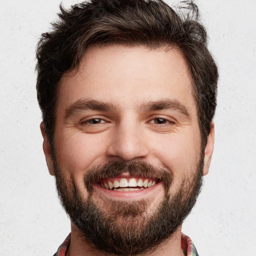

In [11]:
if os.path.isfile('./aligned_images/father_1_01.png'):
  pil_father = Image.open('./aligned_images/father_1_01.png')
  (fat_width, fat_height) = pil_father.size
  resize_fat = max(fat_width, fat_height)/256
  display(pil_father.resize((int(fat_width/resize_fat), int(fat_height/resize_fat))))
else: raise ValueError('No face was found or there is more than one in the photo.')

In [12]:
!python align_images.py ./mother_image ./aligned_images

Aligning mom_1.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result ./aligned_images\mom_1_01.png


2022-12-10 15:25:07.113002: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll
Using TensorFlow backend.


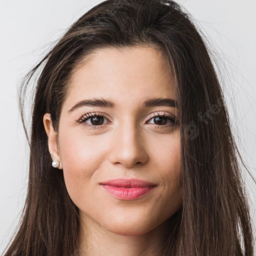

In [12]:
if os.path.isfile('./aligned_images/mom_1_01.png'):
  pil_mother = Image.open('./aligned_images/mom_1_01.png')
  (mot_width, mot_height) = pil_mother.size
  resize_mot = max(mot_width, mot_height)/256
  display(pil_mother.resize((int(mot_width/resize_mot), int(mot_height/resize_mot))))
else: raise ValueError('No face was found or there is more than one in the photo.')

In [13]:
!python encode_images.py \
  --early_stopping False \
  --lr=0.25 \
  --batch_size=2 \
  --iterations=100 \
  --output_video=False \
  ./aligned_images \
  ./generated_images \
  ./latent_representations

2022-12-10 16:29:20.867272: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll
2022-12-10 16:29:22.809925: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX AVX2
2022-12-10 16:29:22.816376: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library nvcuda.dll
2022-12-10 16:29:22.862754: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1060 6GB major: 6 minor: 1 memoryClockRate(GHz): 1.7085
pciBusID: 0000:01:00.0
2022-12-10 16:29:22.862781: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll
2022-12-10 16:29:22.892252: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cublas64_100.dll
2022-12-10 16:29:22.915151: I 

2022-12-10 16:30:31.441318: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B1985C000 next 919 of size 256
2022-12-10 16:30:31.441322: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B1985C100 next 880 of size 256
2022-12-10 16:30:31.441325: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B1985C200 next 895 of size 256
2022-12-10 16:30:31.441330: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B1985C300 next 882 of size 512
2022-12-10 16:30:31.441334: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B1985C500 next 875 of size 256
2022-12-10 16:30:31.441338: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B1985C600 next 898 of size 256
2022-12-10 16:30:31.441342: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B1985C700 next 884 of size 1024
2022-12-10 16:30:31.441346: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse 

2022-12-10 16:30:31.454940: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B27F0AF00 next 1364 of size 2048
2022-12-10 16:30:31.454944: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B27F0B700 next 1365 of size 2048
2022-12-10 16:30:31.454949: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B27F0BF00 next 1366 of size 2048
2022-12-10 16:30:31.454953: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B27F0C700 next 1367 of size 36864
2022-12-10 16:30:31.454957: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B27F15700 next 1368 of size 8192
2022-12-10 16:30:31.454963: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B27F17700 next 1066 of size 256
2022-12-10 16:30:31.454967: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B27F17800 next 1018 of size 256
2022-12-10 16:30:31.454970: I tensorflow/core/common_runtime/bfc_allocator.cc

2022-12-10 16:30:31.457004: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B330BA500 next 1594 of size 9437184
2022-12-10 16:30:31.457008: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B339BA500 next 1595 of size 1179648
2022-12-10 16:30:31.457013: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B33ADA500 next 1596 of size 3538944
2022-12-10 16:30:31.457016: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B33E3A500 next 1597 of size 256
2022-12-10 16:30:31.457020: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B33E3A600 next 1598 of size 262144
2022-12-10 16:30:31.457024: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B33E7A600 next 1599 of size 262144
2022-12-10 16:30:31.457028: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B33EBA600 next 1600 of size 262144
2022-12-10 16:30:31.457033: I tensorflow/core/common_runtime/b

2022-12-10 16:30:55.433604: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B38BF2B00 next 1774 of size 1024
2022-12-10 16:30:55.433608: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B38BF2F00 next 1775 of size 4096
2022-12-10 16:30:55.433612: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B38BF3F00 next 1776 of size 1024
2022-12-10 16:30:55.433616: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B38BF4300 next 1777 of size 2359296
2022-12-10 16:30:55.433621: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B38E34300 next 1778 of size 1048576
2022-12-10 16:30:55.433625: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B38F34300 next 1779 of size 1048576
2022-12-10 16:30:55.433629: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0000000B39034300 next 1780 of size 256
2022-12-10 16:30:55.433633: I tensorflow/core/common_runtime/bfc_all

2022-12-10 16:30:55.438592: I tensorflow/core/common_runtime/bfc_allocator.cc:917] 1 Chunks of size 11730944 totalling 11.19MiB
2022-12-10 16:30:55.438597: I tensorflow/core/common_runtime/bfc_allocator.cc:917] 1 Chunks of size 14680064 totalling 14.00MiB
2022-12-10 16:30:55.438602: I tensorflow/core/common_runtime/bfc_allocator.cc:917] 1 Chunks of size 15187968 totalling 14.48MiB
2022-12-10 16:30:55.438606: I tensorflow/core/common_runtime/bfc_allocator.cc:917] 1 Chunks of size 16045312 totalling 15.30MiB
2022-12-10 16:30:55.438612: I tensorflow/core/common_runtime/bfc_allocator.cc:917] 20 Chunks of size 16777216 totalling 320.00MiB
2022-12-10 16:30:55.438616: I tensorflow/core/common_runtime/bfc_allocator.cc:917] 1 Chunks of size 17170688 totalling 16.38MiB
2022-12-10 16:30:55.438620: I tensorflow/core/common_runtime/bfc_allocator.cc:917] 1 Chunks of size 18329344 totalling 17.48MiB
2022-12-10 16:30:55.438625: I tensorflow/core/common_runtime/bfc_allocator.cc:917] 1 Chunks of size 20

In [15]:
tflib.init_tf()
URL_FFHQ = "./data/karras2019stylegan-ffhq-1024x1024.pkl"
with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)
generator = Generator(Gs_network, batch_size=1, randomize_noise=False)
model_scale = int(2*(math.log(1024,2)-1))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
if len(os.listdir('./generated_images')) == 2:
  first_face = np.load('./latent_representations/father_1_01.npy')
  second_face = np.load('./latent_representations/mom_1_01.npy')
  print("Generation of latent representation is complete! Now comes the fun part.")
else: raise ValueError('Something wrong. It may be impossible to read the face in the photos. Upload other photos and try again.')



---



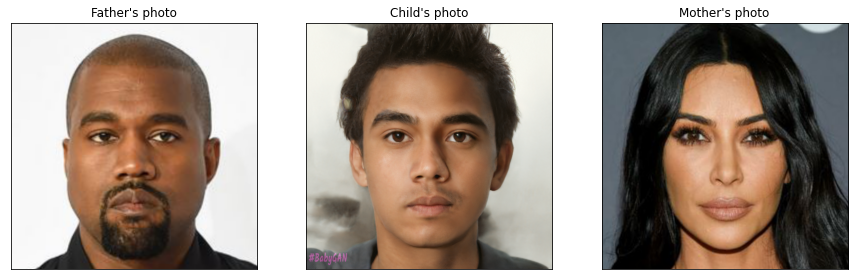

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Generating a child's face</font></b> { run: "auto", display-mode: "form" }
#@markdown **The genes of which parent will prevail and by how much:**

#@markdown *The closer to 0, the more influence the father's genotype will have. Closer to 1 - mother.*
genes_influence = 0.3 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
#@markdown **Styling a photo:**
style = "Default" #@param ["Default", "Father's photo", "Mother's photo"]
if style == "Father's photo": 
  lr = ((np.arange(1,model_scale+1)/model_scale)**genes_influence).reshape((model_scale,1))
  rl = 1-lr
  hybrid_face = (lr*first_face) + (rl*second_face)
elif style == "Mother's photo": 
  lr = ((np.arange(1,model_scale+1)/model_scale)**(1-genes_influence)).reshape((model_scale,1))
  rl = 1-lr
  hybrid_face = (rl*first_face) + (lr*second_face)
else: hybrid_face = ((1-genes_influence)*first_face)+(genes_influence*second_face)
#@markdown **Child's approximate age:**
person_age = 10 #@param {type:"slider", min:10, max:50, step:1}
intensity = -((person_age/5)-6)
#@markdown ---
#@markdown **Download the final image?**
download_image = False #@param {type:"boolean"}
#@markdown **Resolution of the downloaded image:**
resolution = "512" #@param [256, 512, 1024]
size = int(resolution), int(resolution)

face = generate_final_image(hybrid_face, age_direction, intensity)
plot_three_images(face, fs = 15)

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Generating animation of a smooth change of the child's GENDER</font></b> {display-mode: "form" }
!rm -rf /content/BabyGAN/for_animation
!mkdir /content/BabyGAN/for_animation
face_img = []

#@markdown **Child's approximate age:**
person_age = 10 #@param {type:"slider", min:10, max:50, step:1}
intensity = -((person_age/5)-6)
#@markdown **Animation resolution:**
animation_resolution = "512" #@param [256, 512, 1024]
animation_size = int(animation_resolution), int(animation_resolution)
#@markdown **Number of frames:**

#@markdown *The higher value, the smoother the transition between frames.*
frames_number = 50 #@param {type:"slider", min:10, max:50, step:1}

for i in range(1, frames_number):
  gender_influence = i/frames_number
  hybrid_face = ((1-gender_influence)*first_face)+(gender_influence*second_face)
  face = generate_final_images(hybrid_face, age_direction, intensity, i)
  clear_output()
  print(str(i) + " of {} photo generated".format(str(frames_number)))

for j in reversed(face_img):
  face_img.append(j)

#@markdown ---
#@markdown **Download the final animation?**
automatic_download = False #@param {type:"boolean"}
#@markdown *If the checkbox is not checked, the generated animation will be played under this block.*

animation_name = str(person_age) + "_years.mp4"

imageio.mimsave('/content/BabyGAN/for_animation/'+animation_name, face_img)
clear_output()

if automatic_download == True: 
  files.download('/content/BabyGAN/for_animation/'+animation_name)
display(mpy.ipython_display('/content/BabyGAN/for_animation/'+animation_name, height=400, autoplay=1, loop=1))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Generating animation of a smooth change of the child's AGE</font></b> {display-mode: "form" }
!rm -rf for_animation
!mkdir for_animation
face_img = []

#@markdown **The genes of which parent will prevail and by how much:**

#@markdown *The closer to 0, the more influence the father's genotype will have. Closer to 1 - mother.*
gender_influence = 0.8 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
hybrid_face = ((1 - gender_influence) * first_face) + (gender_influence * second_face)
#@markdown **Animation resolution:**
animation_resolution = "512" #@param [256, 512, 1024]
animation_size = int(animation_resolution), int(animation_resolution)
#@markdown **Number of frames:**

#@markdown *The higher value, the smoother the transition between frames.*
frames_number = 50 #@param {type:"slider", min:10, max:50, step:1}
for i in range(0, frames_number, 1):
  intensity = (8*(i/(frames_number-1)))-4
  generate_final_images(hybrid_face, age_direction, intensity, i)
  clear_output()
  print(str(i) + " of {} photo generated".format(str(frames_number)))

for j in reversed(face_img):
  face_img.append(j)

#@markdown ---
#@markdown **Download the final animation?**
automatic_download = False #@param {type:"boolean"}
#@markdown *If the checkbox is not checked, the generated animation will be played under this block.*

if gender_influence <= 0.3:
  animation_name = "boy.mp4"
elif gender_influence >= 0.7:
  animation_name = "girl.mp4"
else:
  animation_name = "animation.mp4"

imageio.mimsave('/content/BabyGAN/for_animation/'+animation_name, face_img)
clear_output()

if automatic_download == True:
  files.download('/content/BabyGAN/for_animation/'+animation_name)
display(mpy.ipython_display('/content/BabyGAN/for_animation/'+animation_name, height=400, autoplay=1, loop=1))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Additional features** *(face modification)*

*____* *↓ Click to open section ↓* *____*

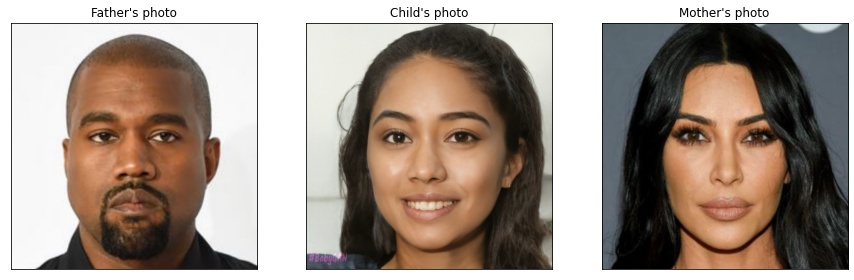

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Change the parameters of the child's face</font></b> { run: "auto", display-mode: "form" }
#@markdown **The genes of which parent will prevail and by how much:**

#@markdown *The closer to 0, the more influence the father's genotype will have. Closer to 1 - mother.*
genes_influence = 0.5 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
#@markdown **Styling a photo:**
style = "Default" #@param ["Default", "Father's photo", "Mother's photo"]
if style == "Father's photo": 
  lr = ((np.arange(1,model_scale+1)/model_scale)**genes_influence).reshape((model_scale,1))
  rl = 1-lr
  hybrid_face = (lr*first_face) + (rl*second_face)
elif style == "Mother's photo": 
  lr = ((np.arange(1,model_scale+1)/model_scale)**(1-genes_influence)).reshape((model_scale,1))
  rl = 1-lr
  hybrid_face = (rl*first_face) + (lr*second_face)
else: hybrid_face = ((1-genes_influence)*first_face)+(genes_influence*second_face)

#@markdown **Option intensity:**
horizontal = -50 #@param {type:"slider", min:-100, max:100, step:1}
horizontal_intensity = horizontal/50
vertical = 0 #@param {type:"slider", min:-100, max:100, step:1}
vertical_intensity = vertical/50
eyes_open = 10 #@param {type:"slider", min:-100, max:100, step:1}
eyes_open_intensity = -(eyes_open/25)
gender = 0 #@param {type:"slider", min:-100, max:100, step:1}
gender_intensity = gender/100
smile = 100 #@param {type:"slider", min:-100, max:100, step:1}
smile_intensity = smile/100
age = -100 #@param {type:"slider", min:-100, max:100, step:1}
age_intensity = -(age/25)

direction_intensity = (horizontal_direction*horizontal_intensity) + (vertical_direction*vertical_intensity) + (eyes_open_direction*eyes_open_intensity) + (gender_direction*gender_intensity) + (smile_direction*smile_intensity) + (age_direction*age_intensity)

#@markdown ---
#@markdown **Download the final image?**
download_image = False #@param {type:"boolean"}
#@markdown **Resolution of the downloaded image:**
resolution = "512" #@param [256, 512, 1024]
size = int(resolution), int(resolution)

face = generate_final_image(hybrid_face, direction_intensity, 1)
plot_three_images(face, fs = 15)

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Generating animation for smooth change of the selected option</font></b> {display-mode: "form" }
!rm -rf for_animation
!mkdir for_animation
face_img = []

#@markdown **The genes of which parent will prevail and by how much:**
gender_influence = 0.5 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
hybrid_face = ((1-gender_influence)*first_face)+(gender_influence*second_face)
#@markdown **Animation resolution:**
animation_resolution = "512" #@param [256, 512, 1024]
animation_size = int(animation_resolution), int(animation_resolution)

#@markdown **Number of frames:**
frames_number = 50 #@param {type:"slider", min:9, max:50, step:1}
#@markdown **Option for animation:**
for i in range(0, frames_number, 1):
  intensity = (100*(i/(frames_number-1)))-50
  
  horizontal_intensity = intensity/25
  vertical_intensity = intensity/25
  eyes_open_intensity = -(intensity/12.5)
  gender_intensity = intensity/50
  smile_intensity = intensity/50
  age_intensity = -(intensity/12.5)

  horizontal = horizontal_direction * horizontal_intensity
  vertical = vertical_direction * vertical_intensity
  eyes_open = eyes_open_direction * eyes_open_intensity
  gender = gender_direction * gender_intensity
  smile = smile_direction * smile_intensity
  age = age_direction * age_intensity

  dir_int = horizontal #@param ["horizontal", "vertical", "eyes_open", "gender", "smile", "age"] {type:"raw"}

  generate_final_images(hybrid_face, dir_int, 1, i)
  clear_output()
  print(str(i) + " of {} photo generated".format(str(frames_number)))

for j in reversed(face_img):
  face_img.append(j)

#@markdown ---
#@markdown **Download the final animation?**
automatic_download = False #@param {type:"boolean"}

if gender_influence <= 0.3:
  animation_name = "boy.mp4"
elif gender_influence >= 0.7:
  animation_name = "girl.mp4"
else:
  animation_name = "animation.mp4"

imageio.mimsave('/content/BabyGAN/for_animation/'+animation_name, face_img)
clear_output()

if automatic_download == True:
  files.download('/content/BabyGAN/for_animation/'+animation_name)
display(mpy.ipython_display('/content/BabyGAN/for_animation/'+animation_name, height=400, autoplay=1, loop=1))

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Generating animation of changing the child's face by 3 parameters</font></b> {display-mode: "form" }
!rm -rf for_animation
!mkdir for_animation
face_img = []

#@markdown **The genes of which parent will prevail and by how much:**
gender_influence = 0.5 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
hybrid_face = ((1-gender_influence)*first_face)+(gender_influence*second_face)
#@markdown **Animation resolution:**
animation_resolution = "256" #@param [256, 512, 1024]
animation_size = int(animation_resolution), int(animation_resolution)
#@markdown **Number of frames:**
frames = 50 #@param {type:"slider", min:10, max:100, step:1}

#@markdown **Select the first option:**
parameter1 = 'angle_horizontal' #@param ["age", "angle_horizontal", "angle_vertical", "eyes_open", "gender", "smile"]
direction_file1 = np.load('/content/BabyGAN/ffhq_dataset/latent_directions/' + parameter1 + '.npy')
intensity1 = 0.5 #@param {type:"slider", min:-5, max:5, step:0.05}
if intensity1 == 0: intensity1 += 0.001
coeffs1 = []
for i in range(0, frames):
  coeffs1.append(round((i*intensity1)/frames,3))


#@markdown **Select the second option:**
parameter2 = 'age' #@param ["age", "angle_horizontal", "angle_vertical", "eyes_open", "gender", "smile"]
direction_file2 = np.load('/content/BabyGAN/ffhq_dataset/latent_directions/' + parameter2 + '.npy')
intensity2 = 5 #@param {type:"slider", min:-5, max:5, step:0.05}
if intensity2 == 0: intensity2 += 0.001
coeffs2 = []
for i in range(0, frames):
  coeffs2.append(round((i*intensity2)/frames,3))

#@markdown **Select the third option:**
parameter3 = 'smile' #@param ["age", "angle_horizontal", "angle_vertical", "eyes_open", "gender", "smile"]
direction_file3 = np.load('/content/BabyGAN/ffhq_dataset/latent_directions/' + parameter3 + '.npy')
intensity3 = 1 #@param {type:"slider", min:-5, max:5, step:0.05}
if intensity3 == 0: intensity3 += 0.001
coeffs3 = []
for i in range(0, frames):
  coeffs3.append(round((i*intensity3)/frames,3))

for i in range(frames):
  direction_intensity1 = direction_file1 * coeffs1[i]
  direction_intensity2 = direction_file2 * coeffs2[i]
  direction_intensity3 = direction_file3 * coeffs3[i]
  direction_intensity = direction_intensity1 + direction_intensity2 + direction_intensity3
  generate_final_images(hybrid_face, direction_intensity, 1, i)
  clear_output()
  print('Generated ' + str(i) + ' photos of ' + str(frames))

add_invert = True
img = os.listdir("for_animation")
img.sort()
clear_output()
print('The animation is being generated. Please wait.')

for j in reversed(face_img):
  face_img.append(j)
face_img = np.array(face_img)
imageio.mimsave("/content/BabyGAN/for_animation/3param.mp4", face_img)
clear_output()

#@markdown ---
#@markdown **Download the final animation?**
automatic_download = False #@param {type:"boolean"}
if automatic_download == True:
  files.download("/content/BabyGAN/for_animation/3param.mp4")
display(mpy.ipython_display("/content/BabyGAN/for_animation/3param.mp4", height=400, autoplay=1, loop=1))